<a href="https://colab.research.google.com/github/kinan-02/SkinCancer-AL/blob/main/Stratiges/custom_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from scipy.stats import entropy
from collections import defaultdict
import argparse
from matplotlib import pyplot as plt
import random
import torch
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

train_df = pd.read_csv('train_dataset/metadata.csv')
test_df = pd.read_csv('test_dataset/metadata.csv')
val_df = pd.read_csv('validation_dataset/metadata.csv')

In [ ]:
print(train_df['diagnosis'].value_counts())

diagnosis
nevus                         1205
melanoma                      1113
pigmented benign keratosis    1099
basal cell carcinoma           514
squamous cell carcinoma        197
vascular lesion                142
actinic keratosis              130
dermatofibroma                 115
Name: count, dtype: int64


In [ ]:
class_mapping = {
    "actinic keratosis": 0,
    "basal cell carcinoma": 1,
    "dermatofibroma": 2,
    "melanoma": 3,
    "nevus": 4,
    "pigmented benign keratosis": 5,
    "squamous cell carcinoma": 6,
    "vascular lesion":7
}
class_mapping

{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'squamous cell carcinoma': 6,
 'vascular lesion': 7}

In [ ]:
from PIL import Image
import os

import torchvision.transforms as transforms

# Define image transformations (resize, convert to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize images to 224x224 (matching ResNet input size)
    transforms.ToTensor()
])

# we made this class to read the data from the file and to use it later in the dataloader
class Dataset():
    def __init__(self, dataframe, transform, train='train'):
        self.dataframe=dataframe
        self.train = train
        self.transform = transform
        self.path_to_image=self._create_path_to_image_dict()
        self.paths=list(self.path_to_image.keys())
        self.labels=list(self.path_to_image.values())

    def _create_path_to_image_dict(self):
      path_to_image={}
      for index,row in self.dataframe.iterrows():
        if self.train == 'train':
          img_path = os.path.join('train_dataset/',row['isic_id']+'.jpg')
        elif self.train == 'test':
          img_path = os.path.join('test_dataset/',row['isic_id']+'.jpg')
        else:
            img_path = os.path.join('validation_dataset/',row['isic_id']+'.jpg')
        label=row['diagnosis']
        path_to_image[img_path]=label
      return path_to_image

    def __len__(self):
        return len(self.paths)

    def __getitem__(self,index):
        img_path=self.paths[index]
        img_label=self.labels[index]
        image=Image.open(img_path)
        image=self.transform(image)
        if self.train == 'val':
            return image, class_mapping[img_label], index
        return image, img_label, index

In [ ]:
train_df = Dataset(train_df, transform)
val_df = Dataset(val_df, transform,train='val')
test_df = Dataset(test_df, transform,train='test')

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.optim import Adam

# Load pre-trained ResNet50 model from torchvision
base_model = models.resnet50(pretrained=True)

num_classes = 8
base_model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(base_model.fc.in_features, 128),  # Add a fully connected layer
    nn.ReLU(),
    nn.Linear(128, num_classes),  # Final layer with number of classes
    nn.Softmax(dim=1)  # Softmax activation for multi-class classification
)

for param in base_model.parameters():
    param.requires_grad = False  # Freeze all layers except the fully connected ones

# Unfreeze the final fully connected layer
for param in base_model.fc.parameters():
    param.requires_grad = True

loss_f = nn.CrossEntropyLoss()
optimizer = Adam(base_model.fc.parameters(), lr=0.0008)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)
x = 5

/anaconda/envs/py38_default/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 4
val_loader = DataLoader(val_df, batch_size=batch_size, shuffle=False)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from transformers import ViTFeatureExtractor, ViTModel

class ActiveLearningPipeline:
    def __init__(self, model,
                 available_pool_indices,
                 train_indices,
                 test_indices,
                 selection_criterion,
                 iterations,
                 budget_per_iter,
                 num_epochs):
        self.model = model
        self.iterations = iterations
        self.budget_per_iter = budget_per_iter
        self.available_pool_indices = available_pool_indices
        self.train_indices = train_indices
        self.test_indices = test_indices
        self.selection_criterion = selection_criterion
        if self.selection_criterion == 'random':
          self.train_indices = []
        self.num_epochs = num_epochs
        self.pool_features = []
        self.pool_indices = []
        self.train_features = []
        # self.best_acc = 0

    def run_pipeline(self):
        """
        Run the active learning pipeline
        :return
        accuracy_scores: list, accuracy scores at each iteration
        """
        accuracy_scores = []
        self._get_features()
        for iteration in range(self.iterations):
            print(f"--------- Number of Iteration {iteration} ---------")
            if self.selection_criterion == 'random':
                self._random_sampling()
            elif self.selection_criterion == 'custom':
                self._custom_sampling()

            train_images = [train_df.__getitem__(index)[0] for index in self.train_indices]
            label_df = [class_mapping[train_df.__getitem__(index)[1]] for index in self.train_indices]
            self._train_model(train_images, label_df)
            self.model.load_state_dict(torch.load(f"best_{self.selection_criterion}_model.pth"))
            accuracy = self._evaluate_model()
            accuracy_scores.append(accuracy)
        return accuracy_scores

    def calculate_class_weights(self, label_counts, num_classes=8):
      """
      calculate class weights to handle data imbalance for the loss function.
      """
        total_samples = sum(label_counts.values())
        class_weights = torch.zeros(num_classes)

        for cls in range(num_classes):
            if cls in label_counts:
                class_weights[cls] = total_samples / (num_classes * label_counts[cls])
            else:
                class_weights[cls] = 1.0  # Handle the case where a class has zero samples in the current epoch

        return class_weights

    def _train_model(self, train_images, label_df):
      """
      This function trains the base model on the provided training set and saves the best-performing model.
      """
      label_counts = defaultdict(int)
      for label in label_df:
                label_counts[label] += 1
      class_weights = self.calculate_class_weights(label_counts, 8).to(device)
      loss_f = nn.CrossEntropyLoss(weight=class_weights)

      train_images_tensor = torch.stack(train_images)
      label_df_tensor = torch.tensor(label_df)
      train_dataset = TensorDataset(train_images_tensor, label_df_tensor)

      batch_size = 32
      train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      best_acc = 0
      for epoch in range(self.num_epochs):
                self.model.train()
                running_loss = 0.0  # Track the running loss
                correct_predictions = 0
                total_predictions = 0
                # Training loop
                for inputs, labels in train_loader:
                    inputs = inputs
                    inputs= inputs.to(device)
                    labels = torch.tensor(labels).to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    outputs = self.model(inputs)
                    # outputs = outputs.logits
                    loss = loss_f(outputs, labels)

                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()

                    # Calculate accuracy
                    _, preds = torch.max(outputs, 1)
                    correct_predictions += torch.sum(preds == labels)
                    total_predictions += inputs.shape[0]

                # Print loss and accuracy at the end of each epoch
                epoch_loss = running_loss / len(train_loader)
                epoch_acc = correct_predictions.double() / total_predictions
                print(f'Epoch [{epoch+1}/{self.num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

                val_acc = self._check_model()
                if val_acc > best_acc:
                    best_acc = val_acc
                    torch.save(self.model.state_dict(), f"best_{self.selection_criterion}_model.pth")
      print("--"*30)

    def _check_model(self):
      """
      Returns the accuracy of the base model on the validation set.
      """
        self.model.eval()
        running_corrects = 0
        total_predictions = 0.0

        with torch.no_grad():
            for inputs, labels, _ in val_loader:
                inputs = inputs.to(device)
                labels = torch.tensor(labels).to(device)

                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)

                running_corrects += torch.sum(preds == labels)
                total_predictions += inputs.shape[0]
        val_acc = running_corrects.double() / total_predictions
        return val_acc.item()

    def _evaluate_model(self):
        """
        Returns the accuracy of the base model on the test set.
        """
        self.model.eval()
        running_corrects = 0
        test_images_tensor = torch.stack(test_images)
        label_df_tensor = torch.tensor(test_label_df)
        test_dataset = TensorDataset(test_images_tensor, label_df_tensor)
        batch_size = 32
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        total_predictions = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = torch.tensor(labels).to(device)

                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)

                running_corrects += torch.sum(preds == labels)
                total_predictions += inputs.shape[0]
        test_acc = running_corrects.double() / total_predictions
        return test_acc.item()

    def _random_sampling(self):
      """
      Adds samples to the training set using a random sampling strategy.
      """
      selected_indices = np.random.choice(self.available_pool_indices, self.budget_per_iter, replace=False)
      selected_indices = selected_indices.tolist()
      self.train_indices = self.train_indices + selected_indices

      available_pool_set = set(self.available_pool_indices)
      train_set = set(self.train_indices)
      self.available_pool_indices = list(available_pool_set - train_set)

    def extract_vae_features(self, dataloader, model, feature_extractor):
        """
        Return the latent vector for each image and the corresponding indices.
        """
        features_list = []
        indices_list = []

        with torch.no_grad():
            for images, indices in dataloader:
                images = images.to(device)
                images_list = [transforms.ToPILImage()(img) for img in images]
                inputs = feature_extractor(images=images_list, return_tensors="pt")
                with torch.no_grad():
                    inputs = inputs.to(device)
                    outputs = model(**inputs)

                x = outputs.last_hidden_state[:, 0, :]
                features_list.append(x.cpu().numpy())

                # Collect indices
                indices_list.extend(indices)

        # Stack all features into a 2D array (n_samples, hidden_dim)
        features = np.vstack(features_list)

        return features, indices_list

    def _get_features(self):
      """
      Creates latent feature vectors for each image in the available pool using a pre-trained Vision Transformer (ViT) model from Google.
      """
        feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
        feature_extractor = feature_extractor.to(device)
        model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        model = model.to(device)

        train_images = [train_df.__getitem__(index)[0] for index in self.train_indices]
        train_images_tensor = torch.stack(train_images)
        label_df_tensor = torch.tensor(self.train_indices)
        train_dataset = TensorDataset(train_images_tensor, label_df_tensor)
        batch_size = 32
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.train_features, self.train_indices = self.extract_vae_features(train_loader, model, feature_extractor)

        X_unlabeled = [train_df.__getitem__(index)[0] for index in self.available_pool_indices]
        pool_images_tensor = torch.stack(X_unlabeled)
        pool_indices_tensor = torch.tensor(self.available_pool_indices)
        pool_dataset = TensorDataset(pool_images_tensor, pool_indices_tensor)

        batch_size = 32
        pool_loader = DataLoader(pool_dataset, batch_size=batch_size, shuffle=False)

        self.pool_features, self.pool_indices = self.extract_vae_features(pool_loader, model, feature_extractor)

    def _custom_sampling(self):
      """
      Adds samples to the training set using a custom sampling strategy.
      """
          misclassified_indices = []
          model = self.model
          model.eval()
          train_images = [train_df.__getitem__(index)[0] for index in self.train_indices]
          label_df = [class_mapping[train_df.__getitem__(index)[1]] for index in self.train_indices]
          train_images_tensor = torch.stack(train_images)
          label_df_tensor = torch.tensor(label_df)
          indices_tensor = torch.tensor(self.train_indices)
          train_dataset = TensorDataset(train_images_tensor, label_df_tensor, indices_tensor)

          batch_size = 32
          train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
          with torch.no_grad():
            for idx, (inputs, labels, indices) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                incorrect = (preds != labels).cpu().numpy()
                misclassified_indices += [i for i, incorrect_flag in zip(indices, incorrect) if incorrect_flag]
          # An array containing the feature vectors of the samples that the model misclassified.
          misclassified_features = np.array([self.train_features[self.train_indices.index(i)] for i in misclassified_indices])

          max_similarities = []
          for pool_feature in self.pool_features:
            # Compute cosine similarity between pool features and misclassified features
            similarities = cosine_similarity([pool_feature], misclassified_features)
            max_similarity = np.max(similarities)
            max_similarities.append(max_similarity)

          #selected_indices is the indices of the samples from the pool that have the highest similarity to the misclassified samples
          selected_indices = np.argsort(max_similarities)[:self.budget_per_iter]
          temp = np.array(self.available_pool_indices)
          selected_indices = temp[selected_indices]

          for i in selected_indices:
              index = self.pool_indices.index(i)

              self.train_features = np.append(self.train_features, [self.pool_features[index]], axis=0)
              self.train_indices.append(i)

              self.pool_features = np.delete(self.pool_features, index, axis=0)
              self.pool_indices.pop(index)

          available_pool_set = set(self.available_pool_indices)
          train_set = set(self.train_indices)
          self.available_pool_indices = list(available_pool_set - train_set)


2024-10-16 10:21:37.265475: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-16 10:21:43.329739: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/
2024-10-16 10:21:43.329772: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cud

In [ ]:
def generate_plot(accuracy_scores_dict):
    """
    Generate a plot
    """
    for criterion, accuracy_scores in accuracy_scores_dict.items():
        plt.plot(range(1, len(accuracy_scores) + 1), accuracy_scores, label=criterion)
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
available_pool_indices = []
for i in range(len(train_df)):
  """Initialize the available pool indices """
    image, label, index = train_df[i]
    available_pool_indices.append(index)

test_indices = []
for i in range(len(test_df)):
  """Initialize the  test set """
    image, label, index = test_df[i]
    test_indices.append(index)

# Extract the images and labels for the collected test indices
test_images = [test_df.__getitem__(index)[0] for index in test_indices]
test_label_df = [class_mapping[test_df.__getitem__(index)[1]] for index in test_indices]

In [ ]:
# This is the initial training set extracted using KMeans++ clustering with ViT (Vision Transformer) feature extraction.
train_indices = [1372,
 1277,
 1255,
 1423,
 2925,
 1963,
 2335,
 1923,
 3791,
 1239,
 909,
 134,
 1547,
 3931,
 2467,
 2832,
 1789,
 3022,
 2424,
 780,
 2412,
 3038,
 2158,
 3335,
 1868,
 1771,
 2015,
 1535,
 710,
 3007]
available_pool_set = set(available_pool_indices)
train_set = set(train_indices)
available_pool_indices = list(available_pool_set - train_set)

In [ ]:
# train_indices = []
iterations = 20
budget_per_iter = 60
num_epoch = 15
selection_criteria = ['custom']
accuracy_scores_dict = defaultdict(list)
model = base_model

/anaconda/envs/py38_default/lib/python3.9/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/anaconda/envs/py38_default/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


--------- Number of Iteration 0 ---------
[tensor(1868), tensor(2015), tensor(1255), tensor(1963), tensor(2335), tensor(2925), tensor(1923), tensor(1547), tensor(3022), tensor(909), tensor(3931), tensor(1277), tensor(1771), tensor(710), tensor(1372), tensor(3791), tensor(3007), tensor(1423), tensor(2832), tensor(1535), tensor(780), tensor(2467), tensor(2158), tensor(3038), tensor(134), tensor(2424), tensor(1239), tensor(3335), tensor(2412)]


/tmp/ipykernel_4004/1467103094.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 2.0695, Accuracy: 0.1111


/tmp/ipykernel_4004/1467103094.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 2.0317, Accuracy: 0.1333
Epoch [3/15], Loss: 1.9597, Accuracy: 0.4333
Epoch [4/15], Loss: 1.9084, Accuracy: 0.4111
Epoch [5/15], Loss: 1.8495, Accuracy: 0.5222
Epoch [6/15], Loss: 1.8091, Accuracy: 0.5889
Epoch [7/15], Loss: 1.7261, Accuracy: 0.6667
Epoch [8/15], Loss: 1.6977, Accuracy: 0.7333
Epoch [9/15], Loss: 1.6499, Accuracy: 0.7111
Epoch [10/15], Loss: 1.5900, Accuracy: 0.8111
Epoch [11/15], Loss: 1.5547, Accuracy: 0.8111
Epoch [12/15], Loss: 1.5307, Accuracy: 0.8444
Epoch [13/15], Loss: 1.5050, Accuracy: 0.8889
Epoch [14/15], Loss: 1.4689, Accuracy: 0.9111
Epoch [15/15], Loss: 1.4649, Accuracy: 0.8667
------------------------------------------------------------


/tmp/ipykernel_4004/1467103094.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 1 ---------
[tensor(1923), tensor(2467), tensor(134), tensor(2981), tensor(3953), tensor(714)]


/tmp/ipykernel_4004/1467103094.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6092, Accuracy: 0.7267


/tmp/ipykernel_4004/1467103094.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5861, Accuracy: 0.7333
Epoch [3/15], Loss: 1.5607, Accuracy: 0.7667
Epoch [4/15], Loss: 1.5329, Accuracy: 0.7800
Epoch [5/15], Loss: 1.5077, Accuracy: 0.7933
Epoch [6/15], Loss: 1.4843, Accuracy: 0.8067
Epoch [7/15], Loss: 1.4808, Accuracy: 0.8267
Epoch [8/15], Loss: 1.4863, Accuracy: 0.8133
Epoch [9/15], Loss: 1.4434, Accuracy: 0.8600
Epoch [10/15], Loss: 1.4430, Accuracy: 0.8400
Epoch [11/15], Loss: 1.4413, Accuracy: 0.8200
Epoch [12/15], Loss: 1.4313, Accuracy: 0.8600
Epoch [13/15], Loss: 1.4188, Accuracy: 0.8667
Epoch [14/15], Loss: 1.4457, Accuracy: 0.8600
Epoch [15/15], Loss: 1.4080, Accuracy: 0.8733
------------------------------------------------------------


/tmp/ipykernel_4004/1467103094.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 2 ---------
[tensor(1923), tensor(134), tensor(2981), tensor(714), tensor(900), tensor(3157), tensor(3910), tensor(2798), tensor(1700), tensor(3287), tensor(1207), tensor(3743), tensor(2536), tensor(3778), tensor(2601), tensor(703)]


/tmp/ipykernel_4004/1467103094.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5909, Accuracy: 0.7333


/tmp/ipykernel_4004/1467103094.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5842, Accuracy: 0.7429
Epoch [3/15], Loss: 1.5528, Accuracy: 0.7667
Epoch [4/15], Loss: 1.5517, Accuracy: 0.7714
Epoch [5/15], Loss: 1.5404, Accuracy: 0.7905
Epoch [6/15], Loss: 1.5437, Accuracy: 0.8095
Epoch [7/15], Loss: 1.5255, Accuracy: 0.8048
Epoch [8/15], Loss: 1.5358, Accuracy: 0.8238
Epoch [9/15], Loss: 1.5210, Accuracy: 0.8476
Epoch [10/15], Loss: 1.5403, Accuracy: 0.8190
Epoch [11/15], Loss: 1.5161, Accuracy: 0.8381
Epoch [12/15], Loss: 1.5222, Accuracy: 0.8571
Epoch [13/15], Loss: 1.5058, Accuracy: 0.8476
Epoch [14/15], Loss: 1.5180, Accuracy: 0.8143
Epoch [15/15], Loss: 1.4969, Accuracy: 0.8619
------------------------------------------------------------


/tmp/ipykernel_4004/1467103094.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 3 ---------
[tensor(1923), tensor(134), tensor(2981), tensor(714), tensor(900), tensor(3157), tensor(3910), tensor(2798), tensor(1700), tensor(3287), tensor(1207), tensor(3743), tensor(2536), tensor(2601), tensor(703), tensor(993), tensor(2174), tensor(3142), tensor(2717), tensor(3169), tensor(2437), tensor(582), tensor(931), tensor(1491), tensor(57), tensor(193), tensor(2128), tensor(501), tensor(1770), tensor(2450), tensor(4501), tensor(2438), tensor(3271), tensor(346), tensor(72), tensor(1339), tensor(3005), tensor(1486), tensor(913), tensor(3182), tensor(475), tensor(1405), tensor(1303), tensor(3151), tensor(3358), tensor(234), tensor(2265)]


/tmp/ipykernel_4004/1467103094.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6683, Accuracy: 0.7296


/tmp/ipykernel_4004/1467103094.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6929, Accuracy: 0.6370
Epoch [3/15], Loss: 1.6205, Accuracy: 0.7481
Epoch [4/15], Loss: 1.6175, Accuracy: 0.7778
Epoch [5/15], Loss: 1.6149, Accuracy: 0.7667
Epoch [6/15], Loss: 1.5846, Accuracy: 0.8037
Epoch [7/15], Loss: 1.5896, Accuracy: 0.7556
Epoch [8/15], Loss: 1.5871, Accuracy: 0.7926
Epoch [9/15], Loss: 1.5643, Accuracy: 0.7852
Epoch [10/15], Loss: 1.5421, Accuracy: 0.8222
Epoch [11/15], Loss: 1.5506, Accuracy: 0.8185
Epoch [12/15], Loss: 1.5407, Accuracy: 0.8148
Epoch [13/15], Loss: 1.5441, Accuracy: 0.8185
Epoch [14/15], Loss: 1.5249, Accuracy: 0.8370
Epoch [15/15], Loss: 1.5415, Accuracy: 0.8407
------------------------------------------------------------


/tmp/ipykernel_4004/1467103094.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 4 ---------
[tensor(134), tensor(714), tensor(900), tensor(3157), tensor(2798), tensor(1700), tensor(1207), tensor(3743), tensor(2536), tensor(2601), tensor(703), tensor(3169), tensor(931), tensor(1491), tensor(193), tensor(2450), tensor(4501), tensor(3271), tensor(1339), tensor(1405), tensor(3358), tensor(2265), tensor(3847), tensor(2305), tensor(2770), tensor(495), tensor(488), tensor(4355), tensor(1282), tensor(3188), tensor(288), tensor(2892), tensor(2013), tensor(3036), tensor(330), tensor(3690), tensor(2913), tensor(539)]


/tmp/ipykernel_4004/1467103094.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5556, Accuracy: 0.7970


/tmp/ipykernel_4004/1467103094.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5535, Accuracy: 0.7939
Epoch [3/15], Loss: 1.5577, Accuracy: 0.7970
Epoch [4/15], Loss: 1.5607, Accuracy: 0.8061
Epoch [5/15], Loss: 1.5523, Accuracy: 0.8121
Epoch [6/15], Loss: 1.5560, Accuracy: 0.7788
Epoch [7/15], Loss: 1.5593, Accuracy: 0.8091
Epoch [8/15], Loss: 1.5397, Accuracy: 0.8091
Epoch [9/15], Loss: 1.5558, Accuracy: 0.8152
Epoch [10/15], Loss: 1.5286, Accuracy: 0.8182
Epoch [11/15], Loss: 1.5354, Accuracy: 0.8364
Epoch [12/15], Loss: 1.5172, Accuracy: 0.8394
Epoch [13/15], Loss: 1.4974, Accuracy: 0.8545
Epoch [14/15], Loss: 1.5219, Accuracy: 0.8576
Epoch [15/15], Loss: 1.5589, Accuracy: 0.7788
------------------------------------------------------------


/tmp/ipykernel_4004/1467103094.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 5 ---------
[tensor(1923), tensor(134), tensor(714), tensor(3157), tensor(2798), tensor(1700), tensor(1207), tensor(2536), tensor(703), tensor(931), tensor(1491), tensor(2450), tensor(4501), tensor(3271), tensor(1339), tensor(1405), tensor(3358), tensor(2265), tensor(3847), tensor(2305), tensor(2770), tensor(488), tensor(4355), tensor(1282), tensor(2013), tensor(3036), tensor(330), tensor(3690), tensor(2913), tensor(539), tensor(3426), tensor(3775), tensor(528), tensor(2813), tensor(52), tensor(1390), tensor(4178), tensor(3086), tensor(2689), tensor(2163), tensor(631), tensor(4231), tensor(51), tensor(291), tensor(889), tensor(685), tensor(2632), tensor(823), tensor(289), tensor(1601)]


/tmp/ipykernel_4004/1467103094.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6057, Accuracy: 0.7436


/tmp/ipykernel_4004/1467103094.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5993, Accuracy: 0.7615
Epoch [3/15], Loss: 1.5944, Accuracy: 0.7513
Epoch [4/15], Loss: 1.5830, Accuracy: 0.7897
Epoch [5/15], Loss: 1.5455, Accuracy: 0.7821
Epoch [6/15], Loss: 1.5649, Accuracy: 0.7846
Epoch [7/15], Loss: 1.5783, Accuracy: 0.7795
Epoch [8/15], Loss: 1.5385, Accuracy: 0.8256
Epoch [9/15], Loss: 1.5732, Accuracy: 0.8205
Epoch [10/15], Loss: 1.5592, Accuracy: 0.8179
Epoch [11/15], Loss: 1.5625, Accuracy: 0.8256
Epoch [12/15], Loss: 1.5182, Accuracy: 0.8154
Epoch [13/15], Loss: 1.5276, Accuracy: 0.8410
Epoch [14/15], Loss: 1.5518, Accuracy: 0.8231
Epoch [15/15], Loss: 1.5407, Accuracy: 0.8231
------------------------------------------------------------


/tmp/ipykernel_4004/1467103094.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 6 ---------
[tensor(1923), tensor(134), tensor(714), tensor(3157), tensor(2798), tensor(1700), tensor(1207), tensor(2536), tensor(703), tensor(931), tensor(1491), tensor(2450), tensor(4501), tensor(3271), tensor(1339), tensor(3358), tensor(2265), tensor(3847), tensor(2305), tensor(2770), tensor(495), tensor(488), tensor(3188), tensor(288), tensor(2013), tensor(3036), tensor(330), tensor(3690), tensor(2913), tensor(539), tensor(3426), tensor(3775), tensor(2813), tensor(52), tensor(4178), tensor(3086), tensor(2689), tensor(2163), tensor(631), tensor(358), tensor(291), tensor(889), tensor(685), tensor(2632), tensor(823), tensor(289), tensor(1601), tensor(236), tensor(2269), tensor(3407), tensor(338), tensor(3383), tensor(681), tensor(1842), tensor(1186), tensor(905), tensor(3558), tensor(2970), tensor(3425), tensor(2753), tensor(1871), tensor(2830), tensor(1658), tensor(1748), tensor(424), tensor(1522), tensor(3208), tensor(224)]


/tmp/ipykernel_4004/1467103094.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.6156, Accuracy: 0.7467


/tmp/ipykernel_4004/1467103094.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.7015, Accuracy: 0.6556
Epoch [3/15], Loss: 1.6497, Accuracy: 0.6711
Epoch [4/15], Loss: 1.6641, Accuracy: 0.7067
Epoch [5/15], Loss: 1.6397, Accuracy: 0.7178
Epoch [6/15], Loss: 1.6638, Accuracy: 0.6711
Epoch [7/15], Loss: 1.6326, Accuracy: 0.7178
Epoch [8/15], Loss: 1.6548, Accuracy: 0.6311
Epoch [9/15], Loss: 1.7055, Accuracy: 0.5867
Epoch [10/15], Loss: 1.5987, Accuracy: 0.7644
Epoch [11/15], Loss: 1.5962, Accuracy: 0.7044
Epoch [12/15], Loss: 1.6989, Accuracy: 0.6378
Epoch [13/15], Loss: 1.6999, Accuracy: 0.5911
Epoch [14/15], Loss: 1.5614, Accuracy: 0.7622
Epoch [15/15], Loss: 1.6094, Accuracy: 0.6756
------------------------------------------------------------


/tmp/ipykernel_4004/1467103094.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 7 ---------
[tensor(1923), tensor(134), tensor(2981), tensor(714), tensor(3157), tensor(2798), tensor(1700), tensor(1207), tensor(3743), tensor(2536), tensor(2601), tensor(703), tensor(993), tensor(931), tensor(1491), tensor(193), tensor(4501), tensor(3271), tensor(1339), tensor(3182), tensor(3151), tensor(3358), tensor(2265), tensor(3847), tensor(2305), tensor(2770), tensor(488), tensor(1282), tensor(3188), tensor(288), tensor(2013), tensor(3036), tensor(2911), tensor(330), tensor(3690), tensor(2913), tensor(539), tensor(3426), tensor(3775), tensor(2813), tensor(52), tensor(3086), tensor(2689), tensor(2163), tensor(2484), tensor(631), tensor(291), tensor(889), tensor(685), tensor(2632), tensor(823), tensor(289), tensor(1601), tensor(236), tensor(2269), tensor(3407), tensor(338), tensor(3383), tensor(681), tensor(2051), tensor(1842), tensor(1186), tensor(511), tensor(905), tensor(1883), tensor(3558), tensor(2970), tensor(3425), tensor(2753), tensor(1871), 

/tmp/ipykernel_4004/1467103094.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5903, Accuracy: 0.7412


/tmp/ipykernel_4004/1467103094.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5762, Accuracy: 0.7588
Epoch [3/15], Loss: 1.5791, Accuracy: 0.7510
Epoch [4/15], Loss: 1.5584, Accuracy: 0.7549
Epoch [5/15], Loss: 1.5506, Accuracy: 0.7863
Epoch [6/15], Loss: 1.5409, Accuracy: 0.7725
Epoch [7/15], Loss: 1.5447, Accuracy: 0.7843
Epoch [8/15], Loss: 1.5347, Accuracy: 0.8000
Epoch [9/15], Loss: 1.5358, Accuracy: 0.8059
Epoch [10/15], Loss: 1.5145, Accuracy: 0.8137
Epoch [11/15], Loss: 1.5237, Accuracy: 0.8118
Epoch [12/15], Loss: 1.5112, Accuracy: 0.8078
Epoch [13/15], Loss: 1.5079, Accuracy: 0.8098
Epoch [14/15], Loss: 1.5094, Accuracy: 0.8314
Epoch [15/15], Loss: 1.5135, Accuracy: 0.8196
------------------------------------------------------------


/tmp/ipykernel_4004/1467103094.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 8 ---------
[tensor(1923), tensor(134), tensor(714), tensor(3157), tensor(2798), tensor(1700), tensor(1207), tensor(2536), tensor(703), tensor(993), tensor(931), tensor(1491), tensor(193), tensor(4501), tensor(3271), tensor(1339), tensor(3358), tensor(2265), tensor(3847), tensor(2305), tensor(488), tensor(3188), tensor(288), tensor(2013), tensor(2911), tensor(3690), tensor(539), tensor(3775), tensor(2813), tensor(52), tensor(3086), tensor(2689), tensor(2163), tensor(631), tensor(291), tensor(685), tensor(2632), tensor(823), tensor(289), tensor(1601), tensor(236), tensor(2269), tensor(3407), tensor(3383), tensor(1186), tensor(2970), tensor(3425), tensor(2753), tensor(1871), tensor(1748), tensor(424), tensor(1522), tensor(224), tensor(1583), tensor(3579), tensor(181), tensor(2099), tensor(3506), tensor(603), tensor(1767), tensor(3509), tensor(683), tensor(3956), tensor(2080), tensor(370), tensor(2136), tensor(4364), tensor(1704), tensor(313), tensor(2279), t

/tmp/ipykernel_4004/1467103094.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5626, Accuracy: 0.7649


/tmp/ipykernel_4004/1467103094.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5282, Accuracy: 0.8018
Epoch [3/15], Loss: 1.5268, Accuracy: 0.7860
Epoch [4/15], Loss: 1.5412, Accuracy: 0.7807
Epoch [5/15], Loss: 1.5321, Accuracy: 0.7895
Epoch [6/15], Loss: 1.5317, Accuracy: 0.8053
Epoch [7/15], Loss: 1.5278, Accuracy: 0.8140
Epoch [8/15], Loss: 1.4979, Accuracy: 0.8263
Epoch [9/15], Loss: 1.5108, Accuracy: 0.8333
Epoch [10/15], Loss: 1.5122, Accuracy: 0.8158
Epoch [11/15], Loss: 1.5027, Accuracy: 0.8333
Epoch [12/15], Loss: 1.5087, Accuracy: 0.8351
Epoch [13/15], Loss: 1.5060, Accuracy: 0.8333
Epoch [14/15], Loss: 1.4974, Accuracy: 0.8474
Epoch [15/15], Loss: 1.5015, Accuracy: 0.8316
------------------------------------------------------------


/tmp/ipykernel_4004/1467103094.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 9 ---------
[tensor(1923), tensor(134), tensor(2981), tensor(714), tensor(3157), tensor(2798), tensor(1700), tensor(1207), tensor(2536), tensor(703), tensor(931), tensor(1491), tensor(4501), tensor(3271), tensor(1339), tensor(3358), tensor(2265), tensor(3847), tensor(2305), tensor(488), tensor(2013), tensor(2911), tensor(539), tensor(3775), tensor(2813), tensor(52), tensor(3086), tensor(2689), tensor(2163), tensor(631), tensor(291), tensor(2632), tensor(1601), tensor(1186), tensor(2970), tensor(3425), tensor(2753), tensor(1748), tensor(424), tensor(1522), tensor(224), tensor(1583), tensor(181), tensor(2099), tensor(603), tensor(3747), tensor(1767), tensor(683), tensor(2080), tensor(370), tensor(2136), tensor(4364), tensor(313), tensor(2279), tensor(3650), tensor(2176), tensor(3453), tensor(54), tensor(1725), tensor(1081), tensor(700), tensor(587), tensor(3540), tensor(2763), tensor(253), tensor(395), tensor(2039), tensor(147), tensor(1938), tensor(1252), t

/tmp/ipykernel_4004/1467103094.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5350, Accuracy: 0.7952


/tmp/ipykernel_4004/1467103094.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5157, Accuracy: 0.8079
Epoch [3/15], Loss: 1.5230, Accuracy: 0.7921
Epoch [4/15], Loss: 1.5107, Accuracy: 0.8127
Epoch [5/15], Loss: 1.5040, Accuracy: 0.8048
Epoch [6/15], Loss: 1.5034, Accuracy: 0.8270
Epoch [7/15], Loss: 1.5133, Accuracy: 0.8111
Epoch [8/15], Loss: 1.5228, Accuracy: 0.8000
Epoch [9/15], Loss: 1.4950, Accuracy: 0.8333
Epoch [10/15], Loss: 1.4989, Accuracy: 0.8333
Epoch [11/15], Loss: 1.4955, Accuracy: 0.8302
Epoch [12/15], Loss: 1.4941, Accuracy: 0.8365
Epoch [13/15], Loss: 1.4940, Accuracy: 0.8444
Epoch [14/15], Loss: 1.5136, Accuracy: 0.8238
Epoch [15/15], Loss: 1.4980, Accuracy: 0.8429
------------------------------------------------------------


/tmp/ipykernel_4004/1467103094.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 10 ---------
[tensor(1923), tensor(134), tensor(2492), tensor(714), tensor(3157), tensor(2798), tensor(1700), tensor(1207), tensor(2536), tensor(703), tensor(993), tensor(931), tensor(1491), tensor(4501), tensor(3271), tensor(1339), tensor(3358), tensor(2265), tensor(3847), tensor(2305), tensor(488), tensor(2013), tensor(2911), tensor(539), tensor(2813), tensor(52), tensor(3086), tensor(2689), tensor(2163), tensor(631), tensor(291), tensor(2632), tensor(823), tensor(1601), tensor(1186), tensor(2970), tensor(3425), tensor(2753), tensor(1748), tensor(424), tensor(1522), tensor(224), tensor(1583), tensor(181), tensor(2099), tensor(603), tensor(3747), tensor(1767), tensor(683), tensor(2080), tensor(3207), tensor(370), tensor(2136), tensor(4364), tensor(313), tensor(2279), tensor(3650), tensor(2176), tensor(3453), tensor(1725), tensor(1081), tensor(587), tensor(253), tensor(1938), tensor(1252), tensor(655), tensor(4014), tensor(1065), tensor(4086), tensor(2519)

/tmp/ipykernel_4004/1467103094.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5298, Accuracy: 0.8000


/tmp/ipykernel_4004/1467103094.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5261, Accuracy: 0.7986
Epoch [3/15], Loss: 1.5308, Accuracy: 0.8058
Epoch [4/15], Loss: 1.5266, Accuracy: 0.8159
Epoch [5/15], Loss: 1.5204, Accuracy: 0.7971
Epoch [6/15], Loss: 1.5115, Accuracy: 0.8159
Epoch [7/15], Loss: 1.5171, Accuracy: 0.8130
Epoch [8/15], Loss: 1.5466, Accuracy: 0.7754
Epoch [9/15], Loss: 1.5130, Accuracy: 0.8159
Epoch [10/15], Loss: 1.5158, Accuracy: 0.8101
Epoch [11/15], Loss: 1.5186, Accuracy: 0.8072
Epoch [12/15], Loss: 1.4970, Accuracy: 0.8478
Epoch [13/15], Loss: 1.5034, Accuracy: 0.8275
Epoch [14/15], Loss: 1.4996, Accuracy: 0.8333
Epoch [15/15], Loss: 1.5118, Accuracy: 0.8101
------------------------------------------------------------


/tmp/ipykernel_4004/1467103094.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 11 ---------
[tensor(1923), tensor(134), tensor(714), tensor(3157), tensor(2798), tensor(1700), tensor(1207), tensor(2536), tensor(703), tensor(993), tensor(931), tensor(1491), tensor(4501), tensor(3271), tensor(1339), tensor(3358), tensor(2265), tensor(3847), tensor(2305), tensor(488), tensor(2013), tensor(539), tensor(2813), tensor(52), tensor(3086), tensor(2689), tensor(2163), tensor(631), tensor(291), tensor(2632), tensor(823), tensor(1601), tensor(1186), tensor(2970), tensor(3425), tensor(2753), tensor(1748), tensor(424), tensor(1522), tensor(224), tensor(1583), tensor(181), tensor(2099), tensor(603), tensor(3747), tensor(1767), tensor(683), tensor(2080), tensor(370), tensor(2136), tensor(4364), tensor(313), tensor(2279), tensor(3650), tensor(2176), tensor(3453), tensor(1725), tensor(1081), tensor(700), tensor(587), tensor(253), tensor(1938), tensor(1252), tensor(655), tensor(4385), tensor(4014), tensor(1065), tensor(4086), tensor(1204), tensor(2519),

/tmp/ipykernel_4004/1467103094.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5671, Accuracy: 0.7653


/tmp/ipykernel_4004/1467103094.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5455, Accuracy: 0.7813
Epoch [3/15], Loss: 1.5873, Accuracy: 0.7080
Epoch [4/15], Loss: 1.5576, Accuracy: 0.7733
Epoch [5/15], Loss: 1.5659, Accuracy: 0.7520
Epoch [6/15], Loss: 1.5346, Accuracy: 0.7787
Epoch [7/15], Loss: 1.5240, Accuracy: 0.7933
Epoch [8/15], Loss: 1.5208, Accuracy: 0.8053
Epoch [9/15], Loss: 1.5433, Accuracy: 0.7840
Epoch [10/15], Loss: 1.5615, Accuracy: 0.7573
Epoch [11/15], Loss: 1.5320, Accuracy: 0.7733
Epoch [12/15], Loss: 1.5114, Accuracy: 0.8213
Epoch [13/15], Loss: 1.5084, Accuracy: 0.8120
Epoch [14/15], Loss: 1.5011, Accuracy: 0.8253
Epoch [15/15], Loss: 1.5153, Accuracy: 0.8173
------------------------------------------------------------


/tmp/ipykernel_4004/1467103094.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 12 ---------
[tensor(1923), tensor(134), tensor(714), tensor(3157), tensor(2798), tensor(1700), tensor(1207), tensor(2536), tensor(703), tensor(931), tensor(1491), tensor(4501), tensor(3271), tensor(1339), tensor(3358), tensor(2265), tensor(3847), tensor(2305), tensor(488), tensor(2013), tensor(539), tensor(2813), tensor(52), tensor(3086), tensor(2689), tensor(2163), tensor(631), tensor(291), tensor(2632), tensor(1601), tensor(3425), tensor(2753), tensor(1748), tensor(424), tensor(1522), tensor(224), tensor(1583), tensor(181), tensor(2099), tensor(603), tensor(3747), tensor(1767), tensor(683), tensor(2080), tensor(2136), tensor(4364), tensor(313), tensor(2279), tensor(3650), tensor(2176), tensor(3453), tensor(1725), tensor(1081), tensor(587), tensor(1938), tensor(655), tensor(4014), tensor(1065), tensor(4086), tensor(1204), tensor(2519), tensor(706), tensor(3115), tensor(2914), tensor(2922), tensor(2794), tensor(3436), tensor(516), tensor(2946), tensor(128

/tmp/ipykernel_4004/1467103094.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5209, Accuracy: 0.7988


/tmp/ipykernel_4004/1467103094.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5442, Accuracy: 0.7716
Epoch [3/15], Loss: 1.5724, Accuracy: 0.7395
Epoch [4/15], Loss: 1.5405, Accuracy: 0.7815
Epoch [5/15], Loss: 1.5325, Accuracy: 0.7852
Epoch [6/15], Loss: 1.5282, Accuracy: 0.8025
Epoch [7/15], Loss: 1.5370, Accuracy: 0.7938
Epoch [8/15], Loss: 1.5412, Accuracy: 0.7889
Epoch [9/15], Loss: 1.5355, Accuracy: 0.7914
Epoch [10/15], Loss: 1.5285, Accuracy: 0.8086
Epoch [11/15], Loss: 1.5173, Accuracy: 0.7951
Epoch [12/15], Loss: 1.5129, Accuracy: 0.8049
Epoch [13/15], Loss: 1.5123, Accuracy: 0.7975
Epoch [14/15], Loss: 1.5088, Accuracy: 0.8123
Epoch [15/15], Loss: 1.5085, Accuracy: 0.8012
------------------------------------------------------------


/tmp/ipykernel_4004/1467103094.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 13 ---------
[tensor(1923), tensor(134), tensor(2620), tensor(714), tensor(3157), tensor(2798), tensor(1700), tensor(1207), tensor(2536), tensor(703), tensor(931), tensor(1491), tensor(4501), tensor(1339), tensor(3358), tensor(2265), tensor(3847), tensor(2305), tensor(488), tensor(3188), tensor(2013), tensor(539), tensor(2813), tensor(52), tensor(3086), tensor(2689), tensor(2163), tensor(631), tensor(291), tensor(2632), tensor(823), tensor(289), tensor(1601), tensor(3425), tensor(2753), tensor(1748), tensor(424), tensor(1522), tensor(224), tensor(1583), tensor(181), tensor(2099), tensor(603), tensor(3747), tensor(1767), tensor(683), tensor(687), tensor(2080), tensor(2136), tensor(4364), tensor(313), tensor(2279), tensor(2176), tensor(3453), tensor(1081), tensor(587), tensor(1938), tensor(655), tensor(4014), tensor(1065), tensor(4086), tensor(1204), tensor(706), tensor(3115), tensor(2922), tensor(2794), tensor(3436), tensor(516), tensor(2946), tensor(128), 

/tmp/ipykernel_4004/1467103094.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5359, Accuracy: 0.7839


/tmp/ipykernel_4004/1467103094.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5474, Accuracy: 0.7724
Epoch [3/15], Loss: 1.5514, Accuracy: 0.7782
Epoch [4/15], Loss: 1.5710, Accuracy: 0.7517
Epoch [5/15], Loss: 1.5609, Accuracy: 0.7782
Epoch [6/15], Loss: 1.5513, Accuracy: 0.7851
Epoch [7/15], Loss: 1.5393, Accuracy: 0.7747
Epoch [8/15], Loss: 1.5376, Accuracy: 0.7885
Epoch [9/15], Loss: 1.5380, Accuracy: 0.7793
Epoch [10/15], Loss: 1.5526, Accuracy: 0.7609
Epoch [11/15], Loss: 1.5876, Accuracy: 0.7149
Epoch [12/15], Loss: 1.5105, Accuracy: 0.8184
Epoch [13/15], Loss: 1.5207, Accuracy: 0.8103
Epoch [14/15], Loss: 1.5172, Accuracy: 0.8195
Epoch [15/15], Loss: 1.5356, Accuracy: 0.7828
------------------------------------------------------------


/tmp/ipykernel_4004/1467103094.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 14 ---------
[tensor(134), tensor(714), tensor(3157), tensor(2798), tensor(1700), tensor(1207), tensor(2536), tensor(703), tensor(993), tensor(931), tensor(1491), tensor(4501), tensor(1339), tensor(3358), tensor(2265), tensor(3847), tensor(2305), tensor(488), tensor(2013), tensor(539), tensor(2813), tensor(52), tensor(3086), tensor(2689), tensor(2163), tensor(631), tensor(291), tensor(685), tensor(2632), tensor(1601), tensor(3425), tensor(2753), tensor(1748), tensor(424), tensor(1522), tensor(224), tensor(1583), tensor(181), tensor(2099), tensor(603), tensor(3747), tensor(1767), tensor(683), tensor(2080), tensor(2136), tensor(4364), tensor(313), tensor(2279), tensor(3650), tensor(2176), tensor(3453), tensor(1081), tensor(587), tensor(1938), tensor(655), tensor(4014), tensor(2873), tensor(1065), tensor(4086), tensor(1204), tensor(706), tensor(3115), tensor(2922), tensor(2794), tensor(3436), tensor(516), tensor(2946), tensor(1110), tensor(128), tensor(4083),

/tmp/ipykernel_4004/1467103094.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5656, Accuracy: 0.7656


/tmp/ipykernel_4004/1467103094.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.6498, Accuracy: 0.6215
Epoch [3/15], Loss: 1.5616, Accuracy: 0.7473
Epoch [4/15], Loss: 1.6692, Accuracy: 0.6011
Epoch [5/15], Loss: 1.6375, Accuracy: 0.6161
Epoch [6/15], Loss: 1.7472, Accuracy: 0.4333
Epoch [7/15], Loss: 1.6419, Accuracy: 0.5978
Epoch [8/15], Loss: 1.6284, Accuracy: 0.6441
Epoch [9/15], Loss: 1.6216, Accuracy: 0.6355
Epoch [10/15], Loss: 1.7143, Accuracy: 0.5290
Epoch [11/15], Loss: 1.6229, Accuracy: 0.6806
Epoch [12/15], Loss: 1.6442, Accuracy: 0.6763
Epoch [13/15], Loss: 1.5747, Accuracy: 0.7419
Epoch [14/15], Loss: 1.6271, Accuracy: 0.6645
Epoch [15/15], Loss: 1.5673, Accuracy: 0.7720
------------------------------------------------------------


/tmp/ipykernel_4004/1467103094.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 15 ---------
[tensor(3038), tensor(134), tensor(3175), tensor(2981), tensor(714), tensor(3157), tensor(1700), tensor(1207), tensor(1727), tensor(2536), tensor(703), tensor(931), tensor(1491), tensor(4501), tensor(1339), tensor(3358), tensor(2265), tensor(3847), tensor(2305), tensor(488), tensor(2013), tensor(539), tensor(2813), tensor(4056), tensor(52), tensor(3086), tensor(2689), tensor(2163), tensor(631), tensor(291), tensor(2632), tensor(1601), tensor(2753), tensor(1748), tensor(424), tensor(1522), tensor(224), tensor(1583), tensor(181), tensor(2099), tensor(603), tensor(3747), tensor(1767), tensor(683), tensor(2080), tensor(2136), tensor(4364), tensor(313), tensor(2279), tensor(3650), tensor(2176), tensor(3453), tensor(3071), tensor(1081), tensor(587), tensor(3540), tensor(253), tensor(1938), tensor(4014), tensor(1065), tensor(4086), tensor(1204), tensor(2519), tensor(706), tensor(3115), tensor(2922), tensor(2794), tensor(3436), tensor(516), tensor(294

/tmp/ipykernel_4004/1467103094.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5416, Accuracy: 0.7717


/tmp/ipykernel_4004/1467103094.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5562, Accuracy: 0.7505
Epoch [3/15], Loss: 1.5490, Accuracy: 0.7697
Epoch [4/15], Loss: 1.5406, Accuracy: 0.7768
Epoch [5/15], Loss: 1.5326, Accuracy: 0.7848
Epoch [6/15], Loss: 1.5254, Accuracy: 0.7980
Epoch [7/15], Loss: 1.5392, Accuracy: 0.7949
Epoch [8/15], Loss: 1.5368, Accuracy: 0.7768
Epoch [9/15], Loss: 1.5164, Accuracy: 0.8152
Epoch [10/15], Loss: 1.5118, Accuracy: 0.8182
Epoch [11/15], Loss: 1.5238, Accuracy: 0.8010
Epoch [12/15], Loss: 1.5142, Accuracy: 0.8131
Epoch [13/15], Loss: 1.5430, Accuracy: 0.7616
Epoch [14/15], Loss: 1.5260, Accuracy: 0.7960
Epoch [15/15], Loss: 1.5173, Accuracy: 0.8081
------------------------------------------------------------


/tmp/ipykernel_4004/1467103094.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 16 ---------
[tensor(134), tensor(3175), tensor(2981), tensor(714), tensor(3157), tensor(2798), tensor(1700), tensor(1207), tensor(1727), tensor(2536), tensor(703), tensor(931), tensor(1491), tensor(4501), tensor(1339), tensor(3358), tensor(2265), tensor(3847), tensor(2305), tensor(814), tensor(488), tensor(2013), tensor(539), tensor(2813), tensor(52), tensor(3086), tensor(2689), tensor(2163), tensor(631), tensor(291), tensor(2632), tensor(1601), tensor(3425), tensor(2753), tensor(1748), tensor(424), tensor(1522), tensor(224), tensor(1267), tensor(1583), tensor(181), tensor(2099), tensor(603), tensor(3747), tensor(1767), tensor(683), tensor(2080), tensor(2136), tensor(4364), tensor(313), tensor(2279), tensor(3650), tensor(2176), tensor(3453), tensor(1081), tensor(587), tensor(1938), tensor(655), tensor(4014), tensor(2873), tensor(1065), tensor(4086), tensor(1204), tensor(2519), tensor(706), tensor(2922), tensor(2794), tensor(516), tensor(2946), tensor(1110

/tmp/ipykernel_4004/1467103094.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5518, Accuracy: 0.7705


/tmp/ipykernel_4004/1467103094.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5424, Accuracy: 0.7810
Epoch [3/15], Loss: 1.5601, Accuracy: 0.7619
Epoch [4/15], Loss: 1.5381, Accuracy: 0.7867
Epoch [5/15], Loss: 1.5377, Accuracy: 0.7714
Epoch [6/15], Loss: 1.5321, Accuracy: 0.7933
Epoch [7/15], Loss: 1.5451, Accuracy: 0.7771
Epoch [8/15], Loss: 1.5345, Accuracy: 0.7914
Epoch [9/15], Loss: 1.5330, Accuracy: 0.7867
Epoch [10/15], Loss: 1.5226, Accuracy: 0.8076
Epoch [11/15], Loss: 1.5343, Accuracy: 0.7905
Epoch [12/15], Loss: 1.5267, Accuracy: 0.7962
Epoch [13/15], Loss: 1.5392, Accuracy: 0.7800
Epoch [14/15], Loss: 1.5388, Accuracy: 0.7952
Epoch [15/15], Loss: 1.5480, Accuracy: 0.7771
------------------------------------------------------------


/tmp/ipykernel_4004/1467103094.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 17 ---------
[tensor(134), tensor(4249), tensor(2620), tensor(2981), tensor(2492), tensor(714), tensor(3157), tensor(1700), tensor(1207), tensor(1727), tensor(2536), tensor(703), tensor(931), tensor(1491), tensor(4501), tensor(1339), tensor(3358), tensor(2265), tensor(3847), tensor(2305), tensor(488), tensor(2013), tensor(2813), tensor(52), tensor(3086), tensor(2689), tensor(2163), tensor(631), tensor(291), tensor(2632), tensor(1601), tensor(2753), tensor(1748), tensor(424), tensor(1522), tensor(224), tensor(1583), tensor(181), tensor(2099), tensor(603), tensor(3747), tensor(1767), tensor(683), tensor(2080), tensor(2136), tensor(4364), tensor(313), tensor(2279), tensor(3650), tensor(2176), tensor(3453), tensor(1081), tensor(587), tensor(1938), tensor(4014), tensor(1065), tensor(4086), tensor(2519), tensor(706), tensor(3115), tensor(2922), tensor(2794), tensor(516), tensor(2946), tensor(128), tensor(4083), tensor(251), tensor(366), tensor(2616), tensor(3199

/tmp/ipykernel_4004/1467103094.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5611, Accuracy: 0.7595


/tmp/ipykernel_4004/1467103094.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5528, Accuracy: 0.7649
Epoch [3/15], Loss: 1.5716, Accuracy: 0.7459
Epoch [4/15], Loss: 1.5625, Accuracy: 0.7595
Epoch [5/15], Loss: 1.5541, Accuracy: 0.7685
Epoch [6/15], Loss: 1.5389, Accuracy: 0.7811
Epoch [7/15], Loss: 1.5591, Accuracy: 0.7622
Epoch [8/15], Loss: 1.5488, Accuracy: 0.7694
Epoch [9/15], Loss: 1.5577, Accuracy: 0.7622
Epoch [10/15], Loss: 1.5234, Accuracy: 0.7991
Epoch [11/15], Loss: 1.5324, Accuracy: 0.8000
Epoch [12/15], Loss: 1.5512, Accuracy: 0.7649
Epoch [13/15], Loss: 1.5348, Accuracy: 0.7946
Epoch [14/15], Loss: 1.5413, Accuracy: 0.7838
Epoch [15/15], Loss: 1.5338, Accuracy: 0.7883
------------------------------------------------------------


/tmp/ipykernel_4004/1467103094.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 18 ---------
[tensor(134), tensor(2981), tensor(714), tensor(3157), tensor(2798), tensor(1700), tensor(1207), tensor(1727), tensor(2536), tensor(1797), tensor(703), tensor(993), tensor(931), tensor(1491), tensor(4501), tensor(1339), tensor(3358), tensor(2265), tensor(3847), tensor(2305), tensor(814), tensor(488), tensor(2013), tensor(539), tensor(2813), tensor(52), tensor(3086), tensor(2689), tensor(2163), tensor(631), tensor(291), tensor(2632), tensor(1601), tensor(2753), tensor(1748), tensor(424), tensor(1522), tensor(224), tensor(1583), tensor(181), tensor(2099), tensor(603), tensor(3747), tensor(1767), tensor(683), tensor(2080), tensor(4364), tensor(313), tensor(2279), tensor(3650), tensor(2176), tensor(3453), tensor(1081), tensor(587), tensor(1938), tensor(4014), tensor(1065), tensor(4086), tensor(2519), tensor(706), tensor(2922), tensor(2794), tensor(516), tensor(2946), tensor(128), tensor(4083), tensor(2121), tensor(366), tensor(2616), tensor(3199),

/tmp/ipykernel_4004/1467103094.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5663, Accuracy: 0.7547


/tmp/ipykernel_4004/1467103094.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5490, Accuracy: 0.7718
Epoch [3/15], Loss: 1.5458, Accuracy: 0.7761
Epoch [4/15], Loss: 1.5681, Accuracy: 0.7573
Epoch [5/15], Loss: 1.5789, Accuracy: 0.7333
Epoch [6/15], Loss: 1.5481, Accuracy: 0.7658
Epoch [7/15], Loss: 1.5377, Accuracy: 0.7752
Epoch [8/15], Loss: 1.5263, Accuracy: 0.7949
Epoch [9/15], Loss: 1.5392, Accuracy: 0.7795
Epoch [10/15], Loss: 1.5256, Accuracy: 0.7923
Epoch [11/15], Loss: 1.5279, Accuracy: 0.8000
Epoch [12/15], Loss: 1.5282, Accuracy: 0.7915
Epoch [13/15], Loss: 1.5464, Accuracy: 0.7624
Epoch [14/15], Loss: 1.5534, Accuracy: 0.7598
Epoch [15/15], Loss: 1.5210, Accuracy: 0.8009
------------------------------------------------------------


/tmp/ipykernel_4004/1467103094.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


--------- Number of Iteration 19 ---------
[tensor(134), tensor(3175), tensor(2981), tensor(2991), tensor(714), tensor(3157), tensor(486), tensor(857), tensor(2798), tensor(1207), tensor(2536), tensor(703), tensor(993), tensor(931), tensor(1491), tensor(4501), tensor(1339), tensor(1380), tensor(3358), tensor(2265), tensor(3847), tensor(2305), tensor(814), tensor(2154), tensor(488), tensor(1282), tensor(2013), tensor(539), tensor(2813), tensor(835), tensor(4056), tensor(52), tensor(3086), tensor(2689), tensor(2163), tensor(631), tensor(291), tensor(2632), tensor(1601), tensor(3425), tensor(2753), tensor(1748), tensor(424), tensor(1522), tensor(224), tensor(181), tensor(2099), tensor(603), tensor(3747), tensor(1767), tensor(683), tensor(2080), tensor(4364), tensor(313), tensor(2279), tensor(3650), tensor(2176), tensor(3453), tensor(1081), tensor(587), tensor(253), tensor(1938), tensor(4014), tensor(2873), tensor(1065), tensor(4086), tensor(2519), tensor(706), tensor(2922), tensor(2794), 

/tmp/ipykernel_4004/1467103094.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [1/15], Loss: 1.5371, Accuracy: 0.7756


/tmp/ipykernel_4004/1467103094.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch [2/15], Loss: 1.5397, Accuracy: 0.7813
Epoch [3/15], Loss: 1.5355, Accuracy: 0.7813
Epoch [4/15], Loss: 1.5558, Accuracy: 0.7569
Epoch [5/15], Loss: 1.5409, Accuracy: 0.7821
Epoch [6/15], Loss: 1.5655, Accuracy: 0.7390
Epoch [7/15], Loss: 1.5344, Accuracy: 0.7951
Epoch [8/15], Loss: 1.5436, Accuracy: 0.7748
Epoch [9/15], Loss: 1.5346, Accuracy: 0.7789
Epoch [10/15], Loss: 1.5297, Accuracy: 0.7870
Epoch [11/15], Loss: 1.5177, Accuracy: 0.7919
Epoch [12/15], Loss: 1.5177, Accuracy: 0.8041
Epoch [13/15], Loss: 1.5170, Accuracy: 0.8016
Epoch [14/15], Loss: 1.5276, Accuracy: 0.8033
Epoch [15/15], Loss: 1.5142, Accuracy: 0.8098
------------------------------------------------------------


/tmp/ipykernel_4004/1467103094.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


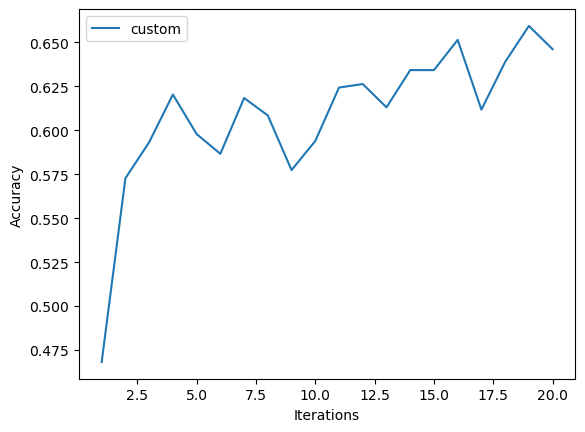

In [ ]:
for criterion in selection_criteria:
    AL_class = ActiveLearningPipeline(model=model,
                                      test_indices=test_indices,
                                      available_pool_indices=available_pool_indices,
                                      train_indices=train_indices,
                                      selection_criterion=criterion,
                                      iterations=iterations,
                                      budget_per_iter=budget_per_iter,
                                      num_epochs=num_epoch)
    accuracy_scores_dict[criterion] = AL_class.run_pipeline()
generate_plot(accuracy_scores_dict)

In [ ]:
accuracy_scores_dict

defaultdict(list,
            {'custom': [0.46825396825396826,
              0.5727513227513227,
              0.5932539682539683,
              0.6203703703703703,
              0.5978835978835979,
              0.5866402116402116,
              0.6183862433862434,
              0.6084656084656084,
              0.5773809523809523,
              0.5939153439153438,
              0.6243386243386243,
              0.6263227513227513,
              0.613095238095238,
              0.6342592592592592,
              0.6342592592592592,
              0.6514550264550264,
              0.6117724867724867,
              0.6388888888888888,
              0.6593915343915343,
              0.6461640211640212]})